In [1]:
import sys
import LangtjernWeather as lw
import numpy as np
import datetime
import pandas as pd
import getpass
import matplotlib
import matplotlib.pyplot as plt
import getpass
import itertools as IT
from itertools import compress
from matplotlib import rc
import shutil
import os
import re
import pickle
import pylab
import statsmodels.api as sm
from patsy import dmatrices
import instantiationFimex as fimex
from subprocess import Popen, PIPE, CalledProcessError
import xarray as xr

#Setting matplotlib style
matplotlib.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None
rc('text', usetex=True)
rc('xtick', labelsize = 16)
rc('ytick', labelsize = 16)
rc('font', size = 16)
#login function
def login():
    username = input("Username: [JLG] ") #default username JLG
    if not username :
        username = "JLG"
    password = getpass.getpass('Password: ')
    return username, password

#Creating directories to store files. This will overwrite if the directory already exists
def create_dir(dir_name) :
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    else :
        shutil.rmtree(dir_name)
        os.makedirs(dir_name)
#Helper function for plotting
def plot_df(df) :
    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows = num_cols, ncols = 1, figsize = (20, num_cols * 5))
    for name,ax_h in zip(df.columns, axes) :
        plt.sca(ax_h)
        plt.plot(df.index,df[name])
        #df[name].plot(ax = ax_h)
        ax_h.set_ylabel(name)
    return fig

def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

#Sanity check
print("Using python version:")
print(sys.version)
print("Paths to python libraries:")
print(sys.path)

#Creating directory to save results
result_dir = './results/'
create_dir(result_dir)    

Using python version:
3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
Paths to python libraries:
['', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python36.zip', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages/IPython/extensions', '/home/jose-luis/.ipython']


# Downloading Langtjern data
## Credentials for Aquamonitor

In [2]:
username,password = login()

#Folder where the downloaded data will be saved
root = "./DownloadedData/"
create_dir(root)

Username: [JLG]  
Password:  ··············


## Defining period to download
This should be the same as in the "Catchment_and_weather" notebook

In [3]:
now = pd.to_datetime('today').strftime('%Y-%m-%d')
#datesToGet = '2019-01-01/{}'.format(now)
datesToGet = '2018-01-01/{}'.format(now)
start = datesToGet.split('/')

finish = pd.datetime.strptime(start[1],'%Y-%m-%d')
start = pd.datetime.strptime(start[0],'%Y-%m-%d')

# finish_dt = pd.datetime.strftime(finish,'%Y-%m-%d')
# start_dt = pd.datetime.strftime(start,'%Y-%m-%d')
# display(finish)

## Downloading meteo data measured locally at Langtjern

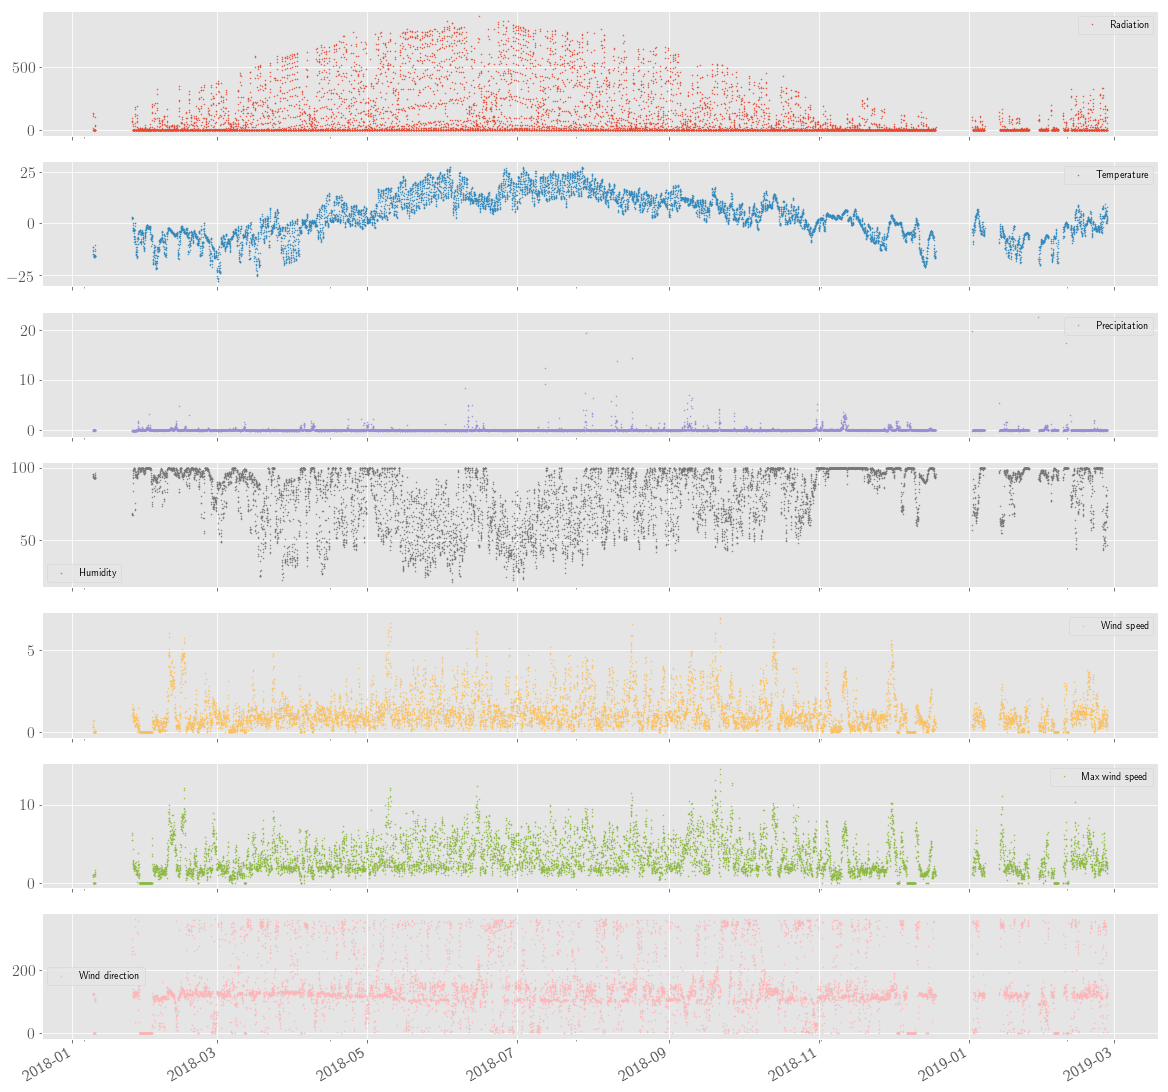

In [4]:
lake = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           62040,
                           'Air')
lake.drop(['ProjectId','ProjectName','StationId','StationCode','StationName','SampleDate_dato','SampleDate_tid'],
         inplace=True, axis=1)
lake.columns = lake.columns.str.strip()
lake.rename(columns={'Lufttemperatur_°C': 'Temperature',
                     'Globalstråling_W/m2' : 'Radiation',
                     'Nedbør_mm' : 'Precipitation',
                     'Relativ luftfuktighet_%': 'Humidity',
                      'Vindhastighet_m/s' : 'Wind speed',
                     'Vindhastighet (maks)_m/s' : 'Max wind speed',
                     'Vindretning_°' : 'Wind direction'                    
                    },
            inplace=True)

#display(lake)
lake.plot(subplots=True,figsize=(20,3*lake.shape[1]),
          marker='.',
          markersize=1,
          linestyle='None')
lake.to_csv('Langtjern_meteo.csv')

fig = plt.gcf()
fig.savefig('Langtjern_meteo.png')

### Formatting inlet data

The data that were read are: Index(['CDOM', 'Temperature', 'gh'], dtype='object')


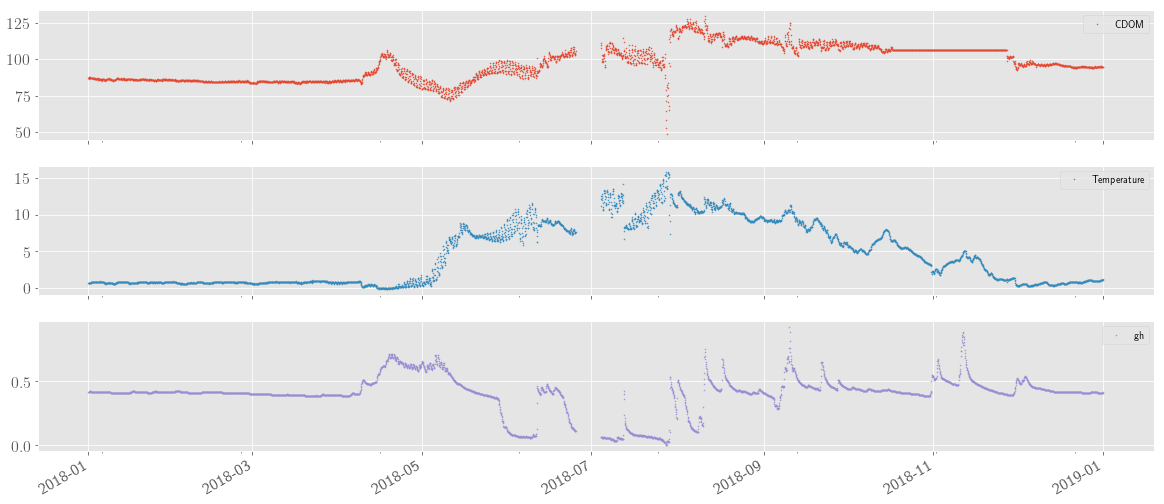

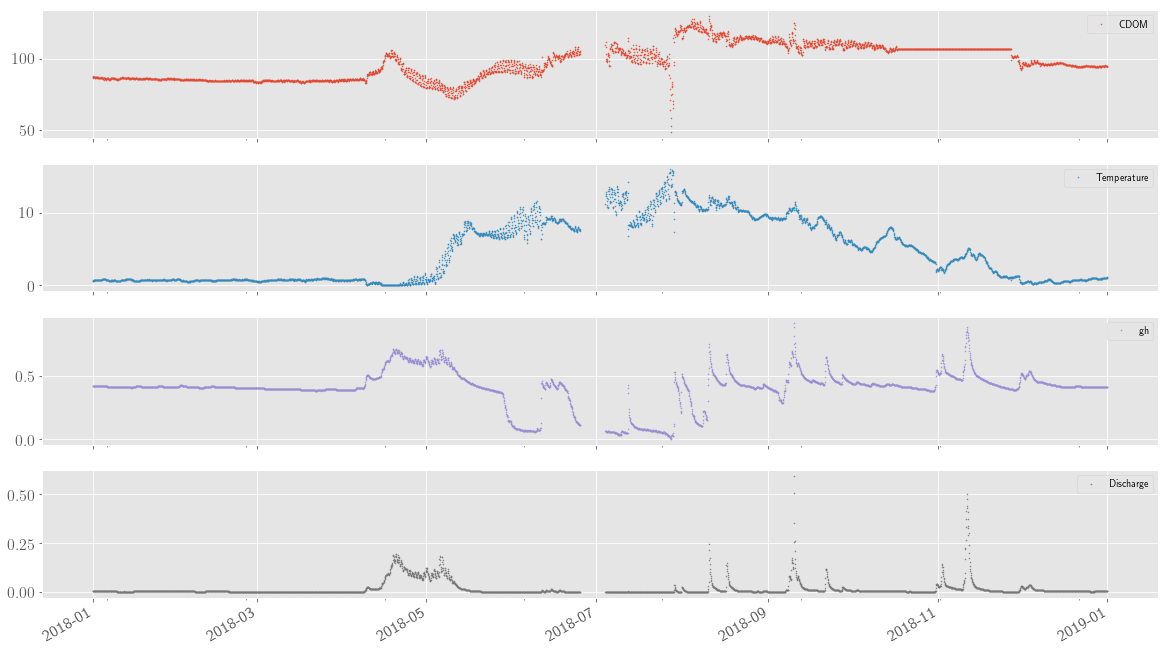

In [5]:
startDate = '2018-01-01 00:00:00'
endDate = '2019-01-01 00:00:00'

inlet = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           63098,
                           'Water')
inlet.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
             'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 

inlet = inlet.rename(columns=lambda x: re.sub('[_/]',' ',x))
inlet = inlet.rename(columns=lambda x: re.sub('µ','u',x))
inlet =  inlet.rename(columns={'Vannstand m':'gh',u'CDOM ug L' : 'CDOM', 'Temperatur C': 'Temperature'})
print("The data that were read are: {}".format(inlet.columns))

inlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

#Transforming stage into discharge
inletQ = lambda x : 2.391* np.power(x - 0.345, 2.5) if (x > 0.345) else 0.0001
inlet['Discharge'] = inlet.gh.apply(inletQ)
#inlet.Discharge *= (4.8 + 0.23) / 0.8
inlet.Temperature[inlet.Temperature < 0.0] = 0.0

inlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(inlet.columns)),linestyle='None',marker='.',markersize=1)

inlet.to_csv('Langtjern_inlet.csv')
fig = plt.gcf()
fig.savefig('Langtjern_inlet.png')

### Formatting outlet data

The data that were read are: Index(['CDOM', 'CO2 ppm', 'Konduktivitet mS m', 'pH', 'Temperature', 'gh'], dtype='object')


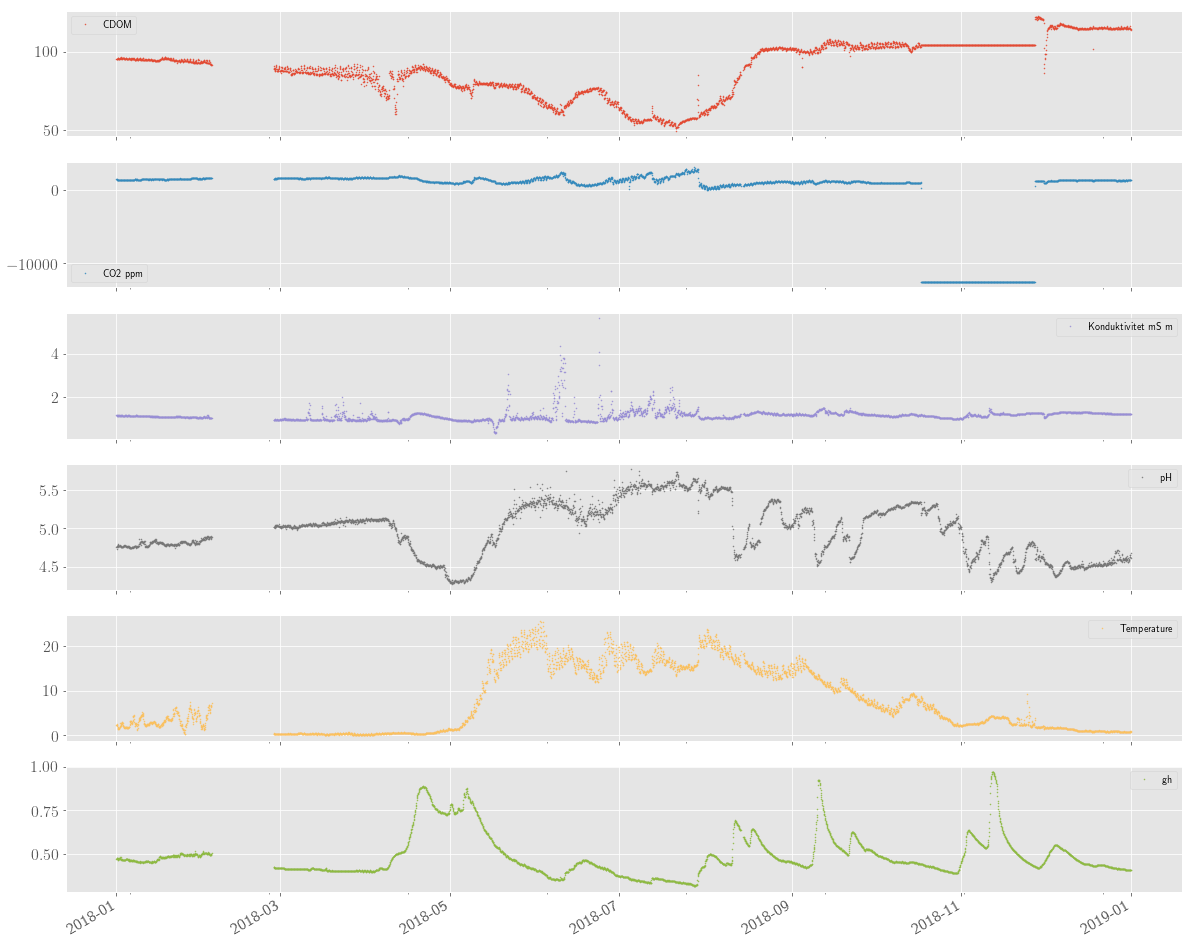

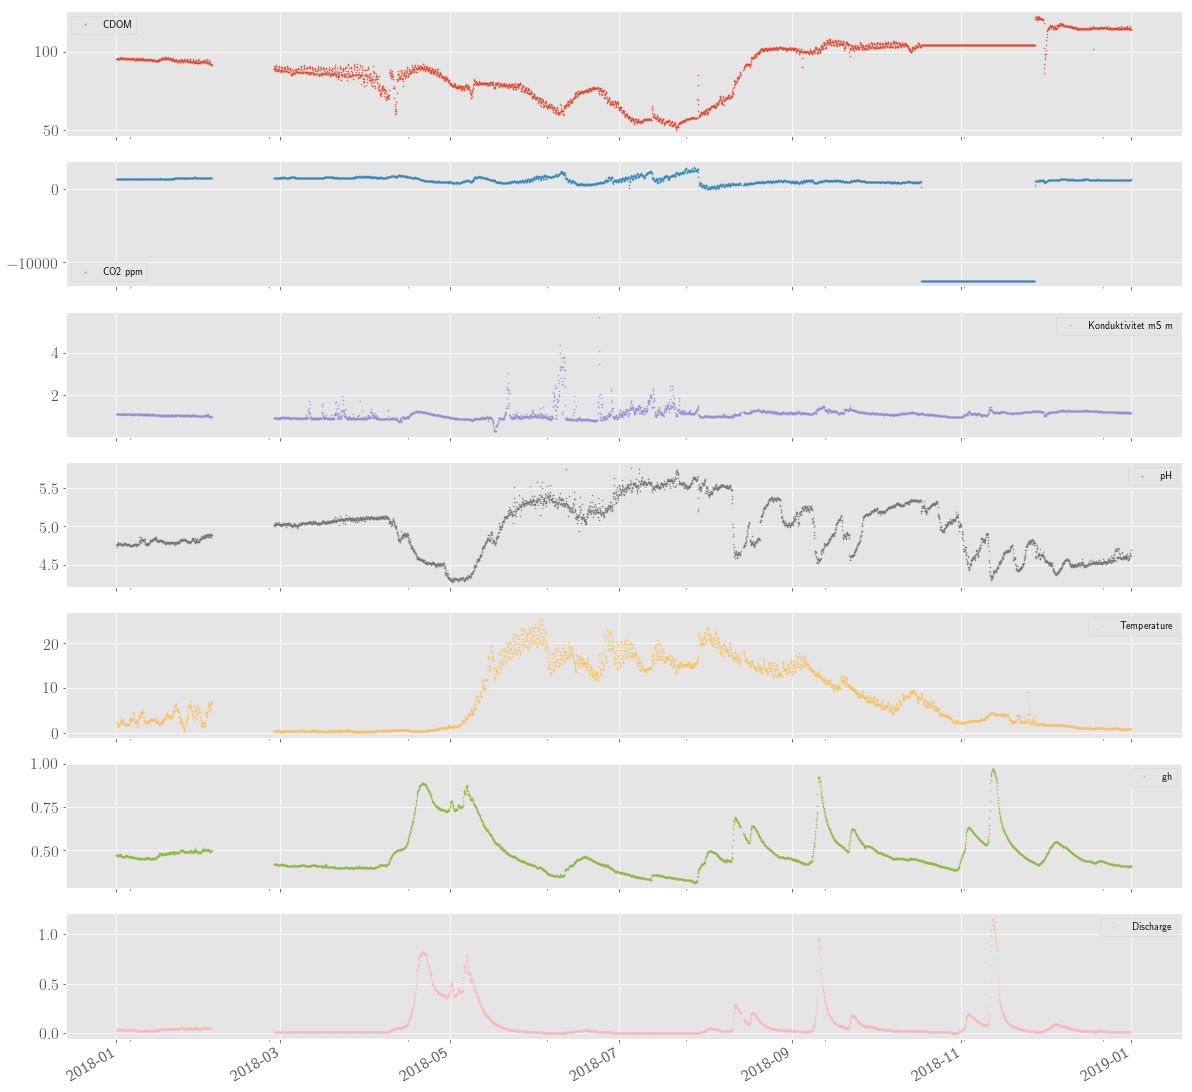

In [6]:
outlet = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'),
                           51356,
                           'Water')
outlet.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
             'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 

outlet = outlet.rename(columns=lambda x: re.sub('[_/]',' ',x))
outlet = outlet.rename(columns=lambda x: re.sub('µ','u',x))
outlet = outlet.rename(columns={'Vannstand m':'gh',u'CDOM ug L' : 'CDOM', 'Temperatur C': 'Temperature'})
print("The data that were read are: {}".format(outlet.columns))

outlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(outlet.columns)),linestyle='None',marker='.',markersize=1)

#Transforming stage into discharge
outletQ = lambda x : 3.2136 * np.power(x - 0.315,2.453) if x > 0.37 else 3.794 * np.power(x - 0.315, 2.692)
outlet['Discharge'] = outlet.gh.apply(outletQ)
outlet.Temperature[outlet.Temperature < 0.0] = 0.0

outlet[pd.Timestamp(startDate):pd.Timestamp(endDate)].plot(subplots=True,figsize=(20,3*len(outlet.columns)),linestyle='None',marker='.',markersize=1)
outlet.to_csv('Langtjern_outlet.csv')

fig = plt.gcf()
fig.savefig('Langtjern_outlet.png')

### Outlet grab samples

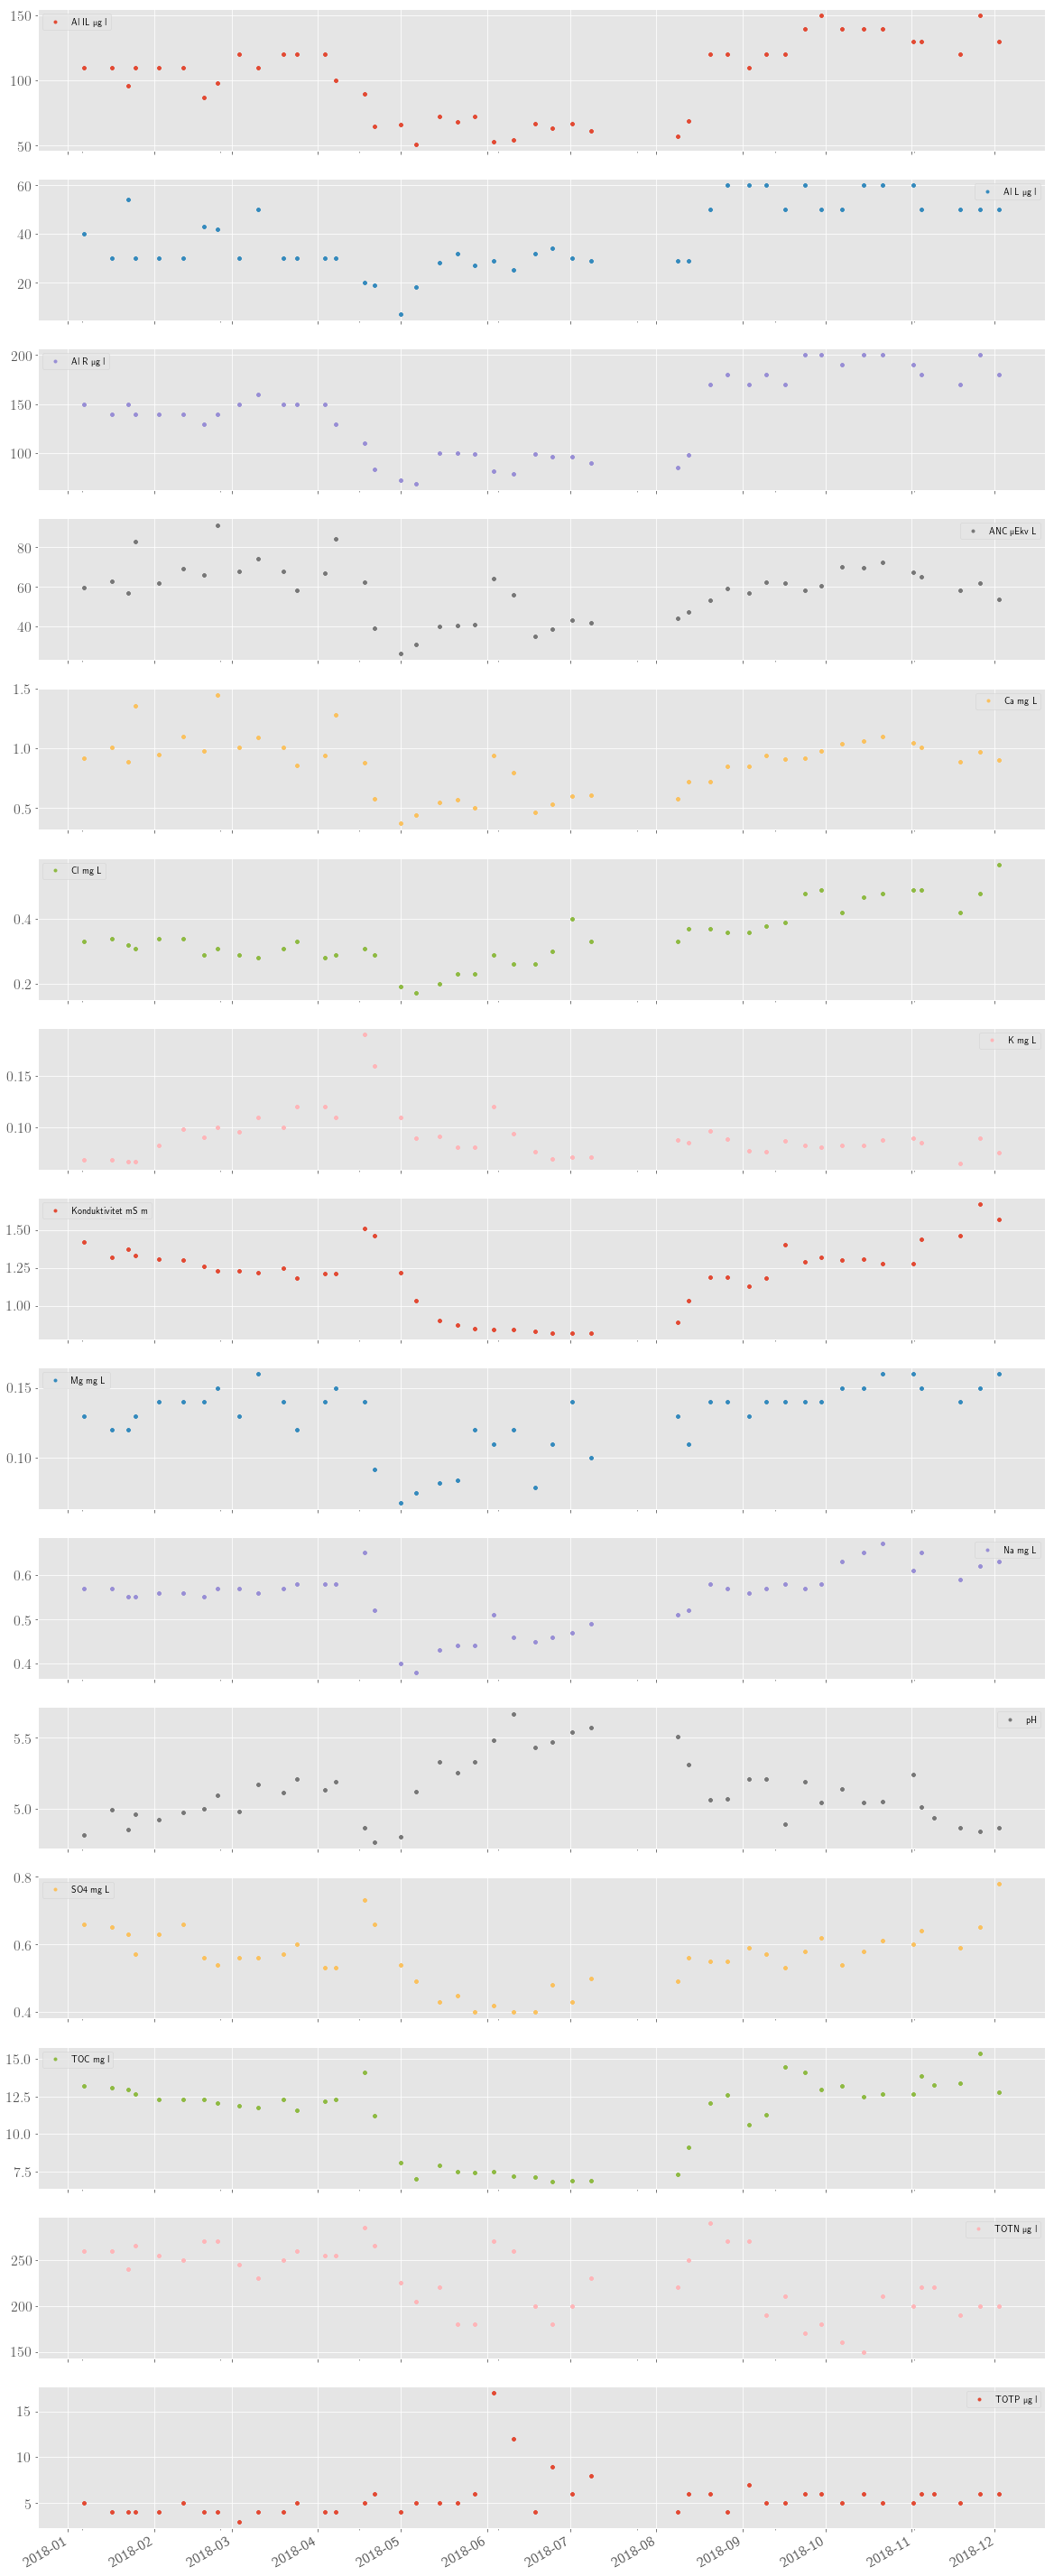

In [7]:
chemistry = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'), 37928, 'Water')
#del password
chemistry.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
                'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 
chemistry.replace('< 1','Null')
chemistry = chemistry.rename(columns=lambda x: re.sub('[_/]',' ',x))
chemistry = chemistry.astype('float64',errors='ignore')

chemistry.plot(subplots=True, figsize=(20,3*len(chemistry.columns)),linestyle='None',marker='.')
chemistry.to_csv('Langtjern_outlet_chem.csv')

fig = plt.gcf()
fig.savefig('Langtjern_outlet_chem.png')

### Inlet grab samples

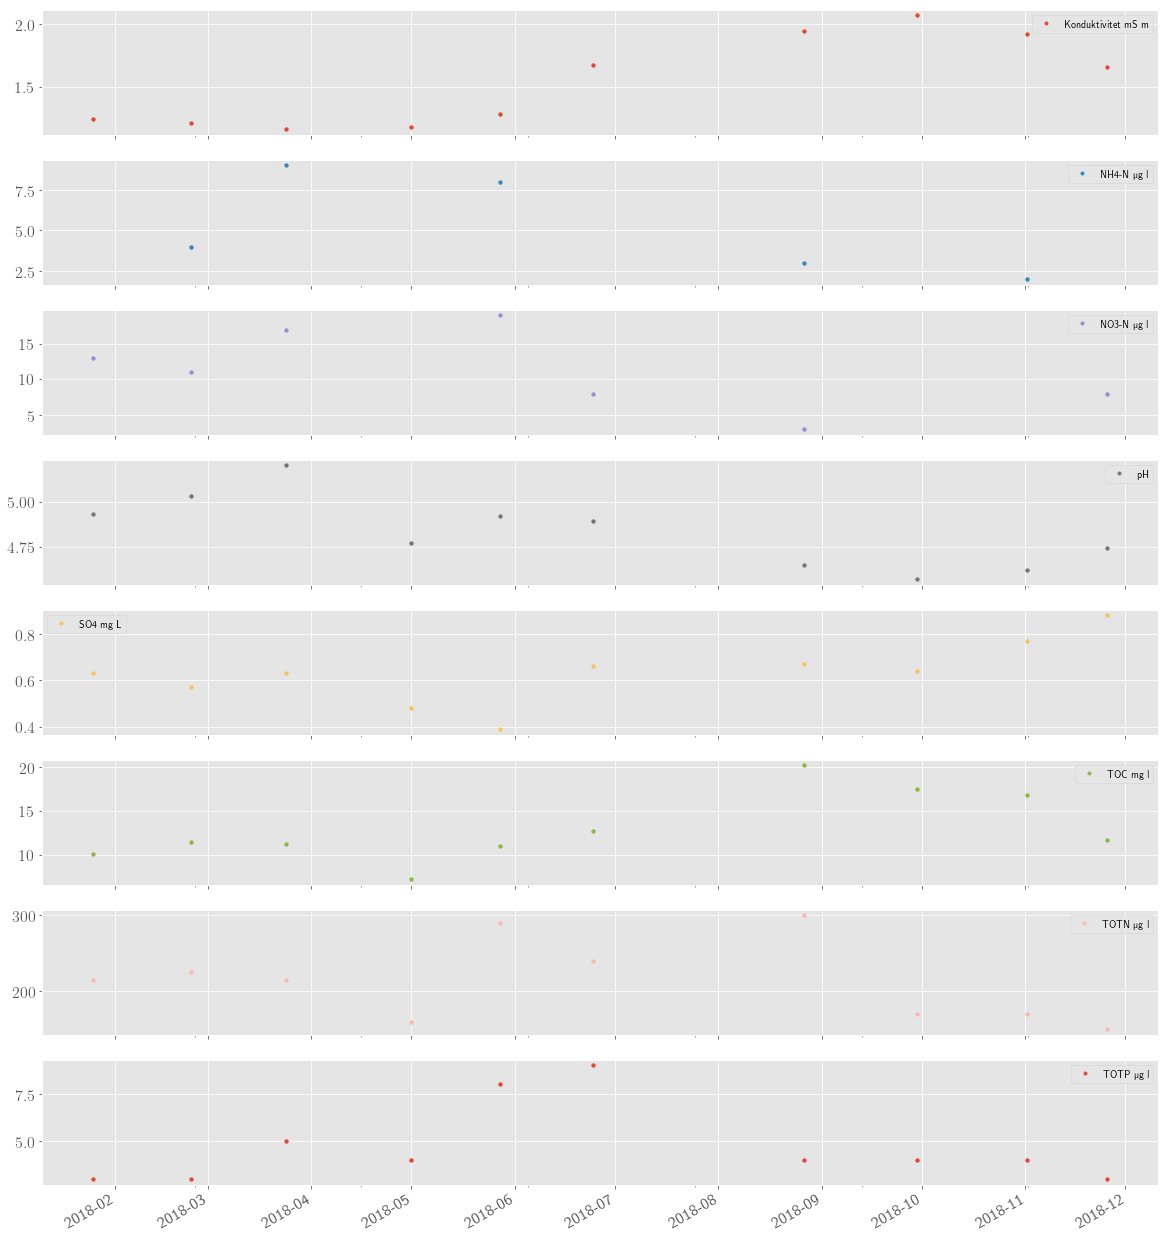

In [8]:
chemistry = lw.getLangtjernData(username,password,root,
                           pd.datetime.strftime(start,'%Y/%m/%d'),
                           pd.datetime.strftime(finish,'%Y/%m/%d'), 37933, 'Water')
#del password
chemistry.drop(['Depth1', 'Depth2','ProjectId', 'ProjectName', 'StationId', 'StationCode',
                'StationName','SampleDate_dato', 'SampleDate_tid'], inplace=True, axis=1) 
# chemistry.replace('< 1','Null')
# chemistry.replace('< 0,06','Null')
chemistry = chemistry[chemistry.applymap(isnumber)]

chemistry = chemistry.rename(columns=lambda x: re.sub('[_/]',' ',x))
chemistry = chemistry.astype('float64',errors='ignore')

chemistry.plot(subplots=True, figsize=(20,3*len(chemistry.columns)),linestyle='None',marker='.')
chemistry.to_csv('Langtjern_inlet_chem.csv')

fig = plt.gcf()
fig.savefig('Langtjern_inlet_chem.png')
